# 🛡️ FinTech Lab 11: Cybersecurity in the AI Era
## Adversarial Robustness Demo — Enhanced Edition

**สิ่งที่จะเรียนในแล็บนี้:**
1. Train โมเดล MLP บน tabular data
2. โจมตีด้วย **FGSM** (Fast Gradient Sign Method)
3. ป้องกันด้วย **Adversarial Training**
4. **[NEW]** ดู Model Insights (activations, gradients, feature importance)
5. **[NEW]** ทดลองเปลี่ยน `epsilon` และ `seed` — บันทึกผลทุกครั้ง
6. **[NEW]** Visualization ครบ: Epsilon Sweep, Confidence Distribution, Perturbation Heatmap

> ⚠️ **ใช้เพื่อการศึกษาเท่านั้น** — ห้ามนำไปใช้กับระบบจริง

## ✅ Step 0: ตรวจสอบ Dependencies

In [1]:
import torch, sklearn, numpy as np
print(f'PyTorch      : {torch.__version__}')
print(f'scikit-learn : {sklearn.__version__}')
print(f'NumPy        : {np.__version__}')
print(f'GPU          : {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "not available"}')

PyTorch      : 2.9.0+cu128
scikit-learn : 1.6.1
NumPy        : 2.0.2
GPU          : Tesla T4


## 📦 Step 1: Import & Config

> 🎛️ **แก้ค่าในบล็อกนี้เพื่อทดลอง** — seed และ epsilon หลัก

In [2]:
from __future__ import annotations
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings, datetime, hashlib
warnings.filterwarnings('ignore')
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ─── 🎛️ CONFIG — ลองเปลี่ยนค่าเหล่านี้ ───────────────────────────
SEED    = 42      # ลองเปลี่ยน: 0, 7, 123, 999
EPSILON = 0.08    # ลองเปลี่ยน: 0.01, 0.05, 0.10, 0.20, 0.50
EPOCHS  = 30
# ──────────────────────────────────────────────────────────────────

def set_seed(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'✅  SEED={SEED}  |  EPSILON={EPSILON}  |  DEVICE={DEVICE}')

✅  SEED=42  |  EPSILON=0.08  |  DEVICE=cuda


## 🏗️ Step 2: MLP with Hooks

**[NEW] เพิ่ม `register_forward_hook`** เพื่อดัก intermediate activations ทุก ReLU layer

```
Input(20) ──► Linear(32) ──► ReLU ──► [hook_0]
                              ▼
                         Linear(16) ──► ReLU ──► [hook_1]
                                        ▼
                                   Linear(1) ──► output
```

In [3]:
class MLP(nn.Module):
    def __init__(self, d_in: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # [NEW] เก็บ activation จาก ReLU แต่ละตัว
        self.activations: dict[str, torch.Tensor] = {}
        self.net[1].register_forward_hook(self._make_hook('relu1'))  # หลัง ReLU ชั้น 1
        self.net[3].register_forward_hook(self._make_hook('relu2'))  # หลัง ReLU ชั้น 2

    def _make_hook(self, name: str):
        def hook(module, input, output):
            self.activations[name] = output.detach().cpu()
        return hook

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)


@torch.no_grad()
def accuracy(logits, y):
    return ((torch.sigmoid(logits) >= 0.5).long() == y).float().mean().item()


print('MLP with activation hooks:')
print(MLP(d_in=20))

MLP with activation hooks:
MLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


## ⚔️ Step 3: FGSM Attack

In [4]:
def fgsm_attack(model, x, y, epsilon=0.05):
    """FGSM: x_adv = x + ε·sign(∇ₓ L)  — sandbox only"""
    x_adv = x.clone().detach().requires_grad_(True)
    loss = nn.BCEWithLogitsLoss()(model(x_adv), y.float())
    loss.backward()
    return (x_adv + epsilon * x_adv.grad.detach().sign()).detach()

print('✅ FGSM defined')

✅ FGSM defined


## 🔁 Step 4: Training Loop (with loss history)

In [5]:
def train_full(
    d_in, xtr, ytr, xte, yte,
    adv_training=False, epsilon=0.05, epochs=30, lr=1e-3
):
    """Train + return model, loss_history, acc_history"""
    model = MLP(d_in=d_in).to(DEVICE)
    opt   = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    losses, accs = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        opt.zero_grad()
        logits = model(xtr)
        loss = loss_fn(logits, ytr.float())
        if adv_training:
            x_adv = fgsm_attack(model, xtr, ytr, epsilon)
            loss = 0.5 * loss + 0.5 * loss_fn(model(x_adv), ytr.float())
        loss.backward()
        opt.step()
        losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            accs.append(accuracy(model(xte), yte))

    return model, losses, accs

print('✅ Training loop defined')

✅ Training loop defined


## 📊 Step 5: เตรียม Dataset

In [6]:
set_seed(SEED)

X, y = make_classification(
    n_samples=6000, n_features=20, n_informative=10,
    n_redundant=4, n_clusters_per_class=2,
    weights=[0.65, 0.35], random_state=SEED,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

xtr = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
ytr = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
xte = torch.tensor(X_test,  dtype=torch.float32).to(DEVICE)
yte = torch.tensor(y_test,  dtype=torch.long).to(DEVICE)

print(f'Train: {xtr.shape}  |  Test: {xte.shape}')
print(f'Positive class (train): {ytr.float().mean():.2%}')

Train: torch.Size([4500, 20])  |  Test: torch.Size([1500, 20])
Positive class (train): 35.24%


## 🧠 Step 6: Train Baseline & Adversarial Models

In [7]:
set_seed(SEED)
print('⏳ Training baseline...')
model,     loss_hist,     acc_hist     = train_full(xtr.shape[1], xtr, ytr, xte, yte,
                                                     adv_training=False, epsilon=EPSILON, epochs=EPOCHS)
print('⏳ Training adversarial defense...')
model_def, loss_hist_def, acc_hist_def = train_full(xtr.shape[1], xtr, ytr, xte, yte,
                                                     adv_training=True,  epsilon=EPSILON, epochs=EPOCHS)

model.eval(); model_def.eval()
with torch.no_grad():
    clean_acc     = accuracy(model(xte),     yte)
    clean_acc_def = accuracy(model_def(xte), yte)

xte_adv     = fgsm_attack(model,     xte, yte, EPSILON)
xte_adv_def = fgsm_attack(model_def, xte, yte, EPSILON)
with torch.no_grad():
    adv_acc     = accuracy(model(xte_adv),         yte)
    adv_acc_def = accuracy(model_def(xte_adv_def), yte)

print(f'\nBaseline  — clean: {clean_acc:.4f}  |  FGSM(ε={EPSILON}): {adv_acc:.4f}')
print(f'Adv-Train — clean: {clean_acc_def:.4f}  |  FGSM(ε={EPSILON}): {adv_acc_def:.4f}')

⏳ Training baseline...
⏳ Training adversarial defense...

Baseline  — clean: 0.7727  |  FGSM(ε=0.08): 0.7093
Adv-Train — clean: 0.7947  |  FGSM(ε=0.08): 0.6933


## 🔬 Step 7: Model Insights — Activations & Feature Importance

**[NEW]** 3 มุมมองภายในโมเดล:
- **Dead neurons**: ReLU ที่ output = 0 เสมอ → โมเดลไม่ได้ใช้ประโยชน์
- **Feature Importance**: feature ไหนมีอิทธิพลต่อ prediction มากสุด
- **Activation comparison**: clean vs adversarial ต่างกันยังไงภายใน

In [8]:
# ── Feature Importance via Input Gradients ──────────────────────────
def get_feature_importance(mdl, x, y):
    """คำนวณ |∂output/∂input| เฉลี่ยทั้ง dataset"""
    x_g = x.clone().requires_grad_(True)
    loss = nn.BCEWithLogitsLoss()(mdl(x_g), y.float())
    loss.backward()
    return x_g.grad.abs().mean(dim=0).detach().cpu().numpy()

imp_clean = get_feature_importance(model, xte, yte)
imp_adv   = get_feature_importance(model, xte_adv, yte)

# ── Activations (clean vs adversarial) via hooks ────────────────────
model.eval()
with torch.no_grad():
    _ = model(xte[:200])           # ดัก activation clean
act_clean_r1 = model.activations['relu1'].numpy()
act_clean_r2 = model.activations['relu2'].numpy()

with torch.no_grad():
    _ = model(xte_adv[:200])       # ดัก activation adversarial
act_adv_r1 = model.activations['relu1'].numpy()
act_adv_r2 = model.activations['relu2'].numpy()

# Dead neuron rate
dead_r1 = (act_clean_r1 == 0).mean(axis=0)   # สัดส่วน sample ที่ neuron นั้น = 0
dead_r2 = (act_clean_r2 == 0).mean(axis=0)
print(f'Dead neurons ReLU-1 (>50% zero): {(dead_r1 > 0.5).sum()} / {len(dead_r1)}')
print(f'Dead neurons ReLU-2 (>50% zero): {(dead_r2 > 0.5).sum()} / {len(dead_r2)}')
print(f'Top-3 important features (clean input): {np.argsort(imp_clean)[::-1][:3]}')

Dead neurons ReLU-1 (>50% zero): 12 / 32
Dead neurons ReLU-2 (>50% zero): 8 / 16
Top-3 important features (clean input): [15  8 10]


## 📊 Step 8: Visualization Suite

**[NEW]** Plot ทั้งหมด 6 กราฟ:
1. Training Loss Curve
2. Test Accuracy Curve
3. Feature Importance (clean vs adversarial)
4. Activation Histogram (ReLU-1)
5. Confidence Distribution (clean vs adversarial)
6. Summary Bar Chart

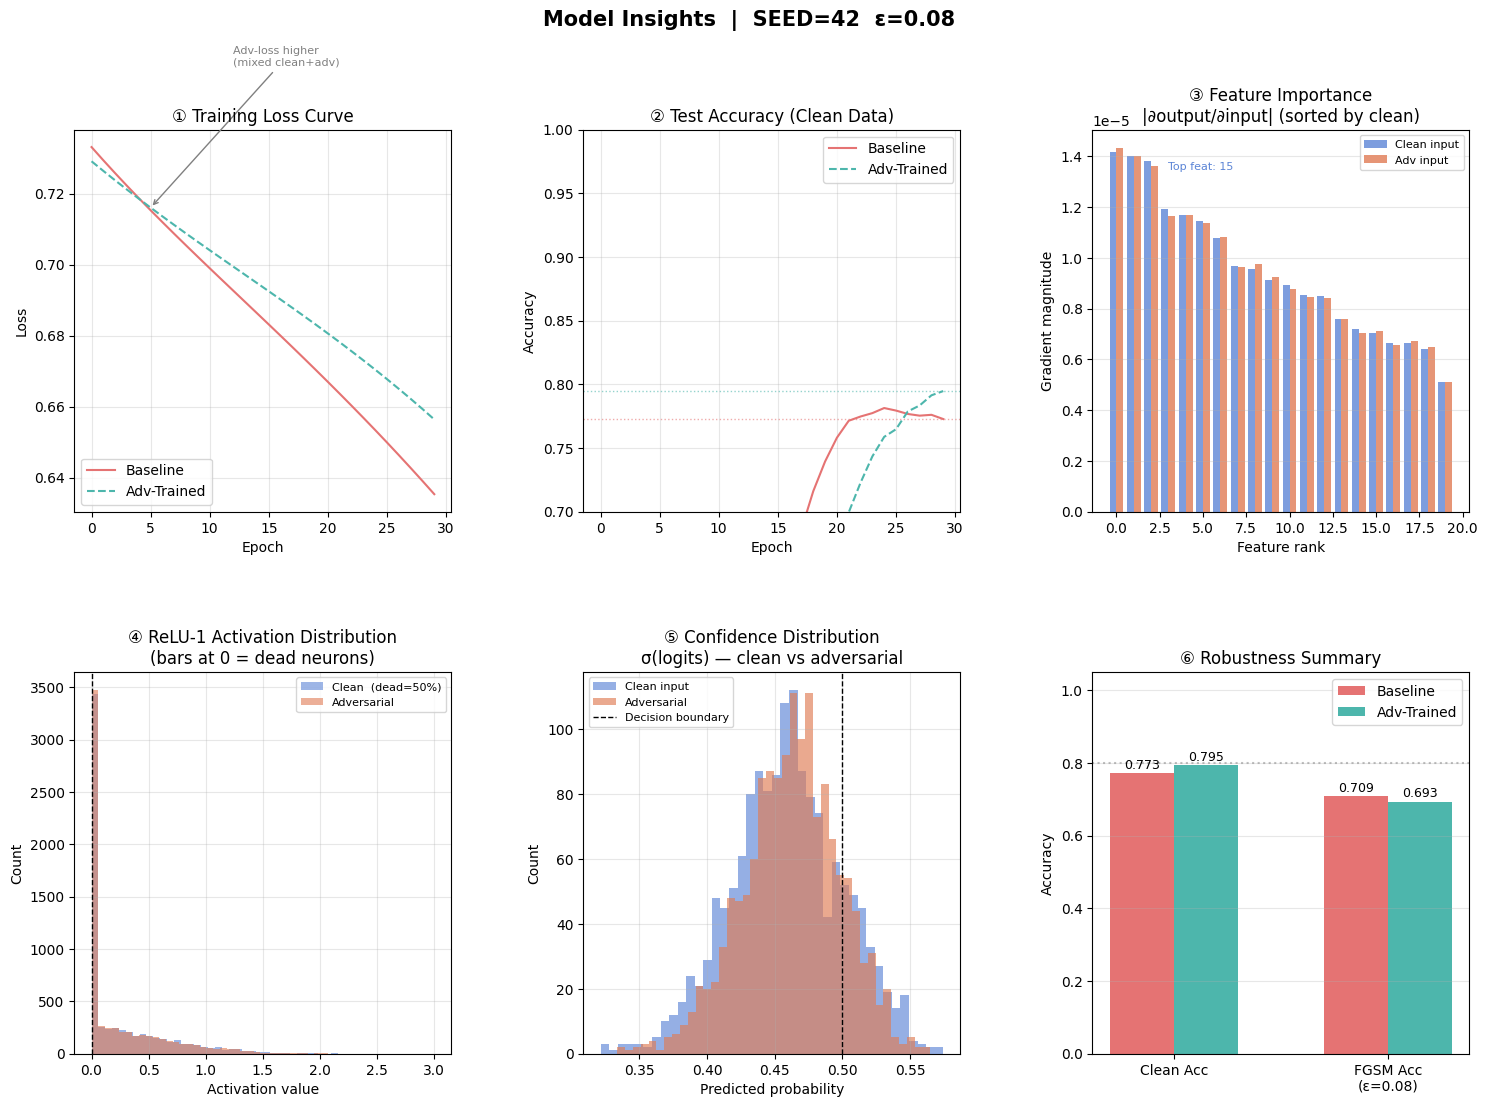


📌 NOTE [SEED=42, ε=0.08]:
   Robustness gap baseline   : +0.0633
   Robustness gap adv-trained: +0.1013


In [9]:
model.eval(); model_def.eval()
with torch.no_grad():
    conf_clean = torch.sigmoid(model(xte)).cpu().numpy()
    conf_adv   = torch.sigmoid(model(xte_adv)).cpu().numpy()

fig = plt.figure(figsize=(18, 12))
fig.suptitle(f'Model Insights  |  SEED={SEED}  ε={EPSILON}', fontsize=15, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.42, wspace=0.35)

# ── 1. Loss Curve ────────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(loss_hist,     color='#E57373', label='Baseline')
ax1.plot(loss_hist_def, color='#4DB6AC', label='Adv-Trained', linestyle='--')
ax1.set_title('① Training Loss Curve')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.legend(); ax1.grid(alpha=0.3)
ax1.annotate('Adv-loss higher\n(mixed clean+adv)', xy=(5, loss_hist_def[5]),
             xytext=(12, loss_hist_def[5]+0.04),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=8, color='gray')

# ── 2. Accuracy Curve ────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(acc_hist,     color='#E57373', label='Baseline')
ax2.plot(acc_hist_def, color='#4DB6AC', label='Adv-Trained', linestyle='--')
ax2.axhline(clean_acc,     color='#E57373', linestyle=':', alpha=0.6, linewidth=1)
ax2.axhline(clean_acc_def, color='#4DB6AC', linestyle=':', alpha=0.6, linewidth=1)
ax2.set_title('② Test Accuracy (Clean Data)')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.legend(); ax2.grid(alpha=0.3)
ax2.set_ylim(0.7, 1.0)

# ── 3. Feature Importance ────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
feat_idx = np.arange(20)
order = np.argsort(imp_clean)[::-1]
ax3.bar(np.arange(20) - 0.2, imp_clean[order], 0.4,
        label='Clean input', color='#5C85D6', alpha=0.8)
ax3.bar(np.arange(20) + 0.2, imp_adv[order],   0.4,
        label='Adv input',   color='#E07B54', alpha=0.8)
ax3.set_title('③ Feature Importance\n|∂output/∂input| (sorted by clean)')
ax3.set_xlabel('Feature rank'); ax3.set_ylabel('Gradient magnitude')
ax3.legend(fontsize=8); ax3.grid(alpha=0.3, axis='y')
top3 = order[:3]
ax3.annotate(f'Top feat: {top3[0]}', xy=(0, imp_clean[order[0]]),
             xytext=(3, imp_clean[order[0]]*0.95), fontsize=8, color='#5C85D6')

# ── 4. Activation Histogram ──────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(act_clean_r1.flatten(), bins=50, alpha=0.6, color='#5C85D6',
         label=f'Clean  (dead={dead_r1.mean():.0%})')
ax4.hist(act_adv_r1.flatten(),   bins=50, alpha=0.6, color='#E07B54',
         label=f'Adversarial')
ax4.axvline(0, color='black', linestyle='--', linewidth=1)
ax4.set_title('④ ReLU-1 Activation Distribution\n(bars at 0 = dead neurons)')
ax4.set_xlabel('Activation value'); ax4.set_ylabel('Count')
ax4.legend(fontsize=8); ax4.grid(alpha=0.3)

# ── 5. Confidence Distribution ───────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(conf_clean, bins=40, alpha=0.65, color='#5C85D6', label='Clean input')
ax5.hist(conf_adv,   bins=40, alpha=0.65, color='#E07B54', label='Adversarial')
ax5.axvline(0.5, color='black', linestyle='--', linewidth=1, label='Decision boundary')
ax5.set_title('⑤ Confidence Distribution\nσ(logits) — clean vs adversarial')
ax5.set_xlabel('Predicted probability'); ax5.set_ylabel('Count')
ax5.legend(fontsize=8); ax5.grid(alpha=0.3)

# ── 6. Summary Bar ───────────────────────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])
cats = ['Clean Acc', f'FGSM Acc\n(ε={EPSILON})']
x = np.arange(2); w = 0.3
b1 = ax6.bar(x - w/2, [clean_acc, adv_acc],     w, label='Baseline',    color='#E57373')
b2 = ax6.bar(x + w/2, [clean_acc_def, adv_acc_def], w, label='Adv-Trained', color='#4DB6AC')
for bar in list(b1) + list(b2):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.004,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
ax6.set_title('⑥ Robustness Summary')
ax6.set_xticks(x); ax6.set_xticklabels(cats)
ax6.set_ylim(0, 1.05); ax6.set_ylabel('Accuracy')
ax6.axhline(0.8, color='gray', linestyle=':', alpha=0.5)
ax6.legend(); ax6.grid(alpha=0.3, axis='y')

plt.show()
print(f'\n📌 NOTE [SEED={SEED}, ε={EPSILON}]:')
print(f'   Robustness gap baseline   : {clean_acc - adv_acc:+.4f}')
print(f'   Robustness gap adv-trained: {clean_acc_def - adv_acc_def:+.4f}')

## 🔄 Step 9: Epsilon Sweep — ดูผลโจมตีเมื่อ ε เปลี่ยน

**[NEW]** วนลูป epsilon 0.0 → 0.5 แล้ว plot กราฟ accuracy vs epsilon

> 📝 **Note**: ยิ่ง ε สูง → perturbation ใหญ่ขึ้น → โมเดลพังเร็วขึ้น  
> Adv-trained model จะ **degrade ช้ากว่า** baseline ในช่วง ε ต่ำ

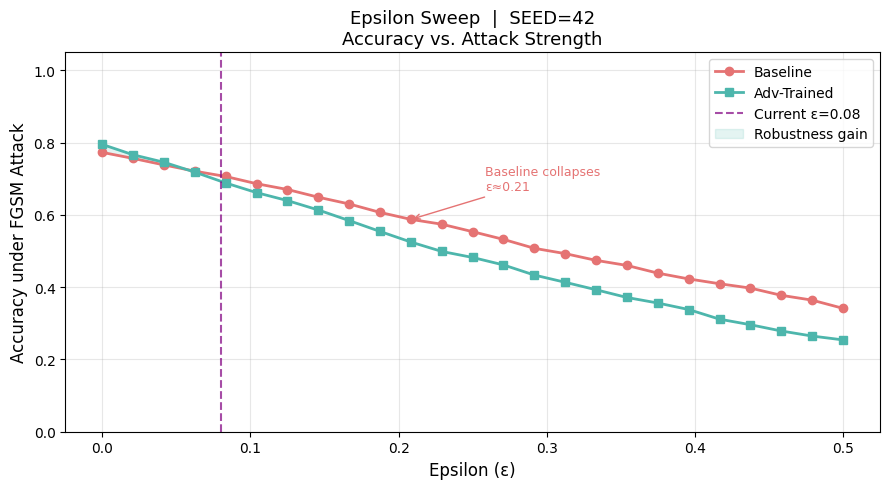


📌 NOTE [SEED=42]:
   ε=0.00 → baseline=0.773, adv-trained=0.795  (clean, no attack)
   ε=0.10 → baseline=0.686, adv-trained=0.661
   ε=0.30 → baseline=0.493, adv-trained=0.413
   ε=0.50 → baseline=0.341, adv-trained=0.254  (large attack)


In [10]:
eps_range = np.linspace(0.0, 0.5, 25)
accs_base, accs_def = [], []

model.eval(); model_def.eval()
for eps in eps_range:
    x_a  = fgsm_attack(model,     xte, yte, eps)
    x_ad = fgsm_attack(model_def, xte, yte, eps)
    with torch.no_grad():
        accs_base.append(accuracy(model(x_a),         yte))
        accs_def.append( accuracy(model_def(x_ad),    yte))

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(eps_range, accs_base, 'o-', color='#E57373', label='Baseline',    linewidth=2)
ax.plot(eps_range, accs_def,  's-', color='#4DB6AC', label='Adv-Trained', linewidth=2)
ax.axvline(EPSILON, color='purple', linestyle='--', alpha=0.7, label=f'Current ε={EPSILON}')
ax.fill_between(eps_range, accs_def, accs_base,
                where=[d > b for d, b in zip(accs_def, accs_base)],
                alpha=0.15, color='#4DB6AC', label='Robustness gain')
ax.set_xlabel('Epsilon (ε)', fontsize=12)
ax.set_ylabel('Accuracy under FGSM Attack', fontsize=12)
ax.set_title(f'Epsilon Sweep  |  SEED={SEED}\nAccuracy vs. Attack Strength', fontsize=13)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=10); ax.grid(alpha=0.3)

# หา break-even point
for i, (b, d) in enumerate(zip(accs_base, accs_def)):
    if b < 0.6:
        ax.annotate(f'Baseline collapses\nε≈{eps_range[i]:.2f}',
                    xy=(eps_range[i], b), xytext=(eps_range[i]+0.05, b+0.08),
                    arrowprops=dict(arrowstyle='->', color='#E57373'),
                    fontsize=9, color='#E57373')
        break

plt.tight_layout()
plt.show()

print(f'\n📌 NOTE [SEED={SEED}]:')
print(f'   ε=0.00 → baseline={accs_base[0]:.3f}, adv-trained={accs_def[0]:.3f}  (clean, no attack)')
print(f'   ε=0.10 → baseline={accs_base[5]:.3f}, adv-trained={accs_def[5]:.3f}')
print(f'   ε=0.30 → baseline={accs_base[15]:.3f}, adv-trained={accs_def[15]:.3f}')
print(f'   ε=0.50 → baseline={accs_base[-1]:.3f}, adv-trained={accs_def[-1]:.3f}  (large attack)')

## 🎲 Step 10: Seed Sweep — ดูผลเมื่อ random seed เปลี่ยน

**[NEW]** ทดสอบ 8 seeds ดูว่าผลลัพธ์ stable แค่ไหน

> 📝 **Note**: ถ้าผลต่างกันมากระหว่าง seed → โมเดลมี high variance → ควรใช้ k-fold หรือ ensemble

In [11]:
SEEDS_TEST = [0, 7, 21, 42, 99, 123, 456, 999]
results = []

for s in SEEDS_TEST:
    set_seed(s)
    Xs, ys = make_classification(
        n_samples=6000, n_features=20, n_informative=10,
        n_redundant=4, n_clusters_per_class=2,
        weights=[0.65, 0.35], random_state=s,
    )
    Xtr, Xte, ytr_, yte_ = train_test_split(Xs, ys, test_size=0.25, stratify=ys, random_state=s)
    sc = StandardScaler()
    Xtr = sc.fit_transform(Xtr); Xte = sc.transform(Xte)
    xt = torch.tensor(Xtr, dtype=torch.float32).to(DEVICE)
    yt = torch.tensor(ytr_, dtype=torch.long).to(DEVICE)
    xe = torch.tensor(Xte, dtype=torch.float32).to(DEVICE)
    ye = torch.tensor(yte_, dtype=torch.long).to(DEVICE)

    m, _, _ = train_full(xt.shape[1], xt, yt, xe, ye, adv_training=False, epsilon=EPSILON, epochs=EPOCHS)
    m.eval()
    with torch.no_grad(): ca = accuracy(m(xe), ye)
    xa = fgsm_attack(m, xe, ye, EPSILON)
    with torch.no_grad(): aa = accuracy(m(xa), ye)
    results.append({'seed': s, 'clean': ca, 'adv': aa, 'drop': ca - aa})
    print(f'  seed={s:>4} | clean={ca:.4f} | adv={aa:.4f} | drop={ca-aa:.4f}')

import statistics
drops = [r['drop'] for r in results]
print(f'\n📌 NOTE — Accuracy drop across seeds:')
print(f'   Mean drop : {statistics.mean(drops):.4f}')
print(f'   Std  drop : {statistics.stdev(drops):.4f}')
print(f'   Min  drop : {min(drops):.4f}  (seed={results[drops.index(min(drops))]["seed"]})')
print(f'   Max  drop : {max(drops):.4f}  (seed={results[drops.index(max(drops))]["seed"]})')
if statistics.stdev(drops) > 0.03:
    print('   ⚠️  High variance — results are seed-sensitive!')
else:
    print('   ✅  Low variance — model is stable across seeds')

  seed=   0 | clean=0.7080 | adv=0.6753 | drop=0.0327
  seed=   7 | clean=0.7740 | adv=0.6713 | drop=0.1027
  seed=  21 | clean=0.7247 | adv=0.6987 | drop=0.0260
  seed=  42 | clean=0.7727 | adv=0.7093 | drop=0.0633
  seed=  99 | clean=0.6513 | adv=0.6500 | drop=0.0013
  seed= 123 | clean=0.6747 | adv=0.6500 | drop=0.0247
  seed= 456 | clean=0.6487 | adv=0.6487 | drop=0.0000
  seed= 999 | clean=0.6453 | adv=0.6127 | drop=0.0327

📌 NOTE — Accuracy drop across seeds:
   Mean drop : 0.0354
   Std  drop : 0.0337
   Min  drop : 0.0000  (seed=456)
   Max  drop : 0.1027  (seed=7)
   ⚠️  High variance — results are seed-sensitive!


## 📊 Step 11: Seed Comparison Plot

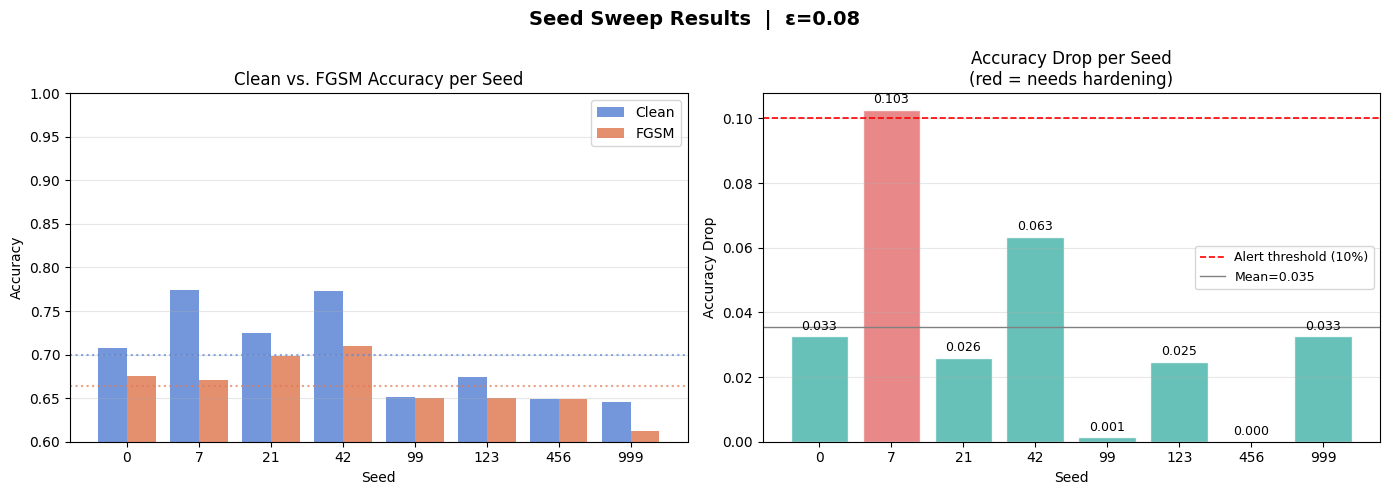

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Seed Sweep Results  |  ε={EPSILON}', fontsize=14, fontweight='bold')

seeds_l  = [r['seed']  for r in results]
cleans   = [r['clean'] for r in results]
advs     = [r['adv']   for r in results]
drop_l   = [r['drop']  for r in results]

# Plot 1: clean vs adv per seed
ax = axes[0]
x  = np.arange(len(seeds_l))
ax.bar(x - 0.2, cleans, 0.4, label='Clean', color='#5C85D6', alpha=0.85)
ax.bar(x + 0.2, advs,   0.4, label='FGSM',  color='#E07B54', alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels([str(s) for s in seeds_l])
ax.set_xlabel('Seed'); ax.set_ylabel('Accuracy')
ax.set_title('Clean vs. FGSM Accuracy per Seed')
ax.set_ylim(0.6, 1.0); ax.legend(); ax.grid(alpha=0.3, axis='y')
ax.axhline(np.mean(cleans), color='#5C85D6', linestyle=':', alpha=0.7)
ax.axhline(np.mean(advs),   color='#E07B54', linestyle=':', alpha=0.7)

# Plot 2: accuracy drop per seed
ax2 = axes[1]
colors = ['#E57373' if d > 0.10 else '#4DB6AC' for d in drop_l]
bars = ax2.bar(x, drop_l, color=colors, alpha=0.85, edgecolor='white')
for bar, d in zip(bars, drop_l):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{d:.3f}', ha='center', fontsize=9)
ax2.axhline(0.10, color='red', linestyle='--', linewidth=1.2, label='Alert threshold (10%)')
ax2.axhline(np.mean(drop_l), color='gray', linestyle='-', linewidth=1, label=f'Mean={np.mean(drop_l):.3f}')
ax2.set_xticks(x); ax2.set_xticklabels([str(s) for s in seeds_l])
ax2.set_xlabel('Seed'); ax2.set_ylabel('Accuracy Drop')
ax2.set_title('Accuracy Drop per Seed\n(red = needs hardening)')
ax2.legend(fontsize=9); ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 📋 Step 12: Audit Log + Experiment Notes

**[NEW]** บันทึกผลทุก run อัตโนมัติ พร้อม alert

> 📝 **ทดลองเปลี่ยน SEED/EPSILON ในบล็อก Step 1 แล้วรันใหม่ — log จะอัปเดตอัตโนมัติ**

In [13]:
dataset_hash = hashlib.md5(X.tobytes()).hexdigest()[:12]

log = {
    'timestamp'        : datetime.datetime.now().isoformat(timespec='seconds'),
    'seed'             : SEED,
    'epsilon'          : EPSILON,
    'dataset_hash'     : dataset_hash,
    'baseline_clean'   : round(clean_acc, 4),
    'baseline_fgsm'    : round(adv_acc,   4),
    'baseline_drop'    : round(clean_acc - adv_acc, 4),
    'advtrain_clean'   : round(clean_acc_def, 4),
    'advtrain_fgsm'    : round(adv_acc_def,   4),
    'advtrain_drop'    : round(clean_acc_def - adv_acc_def, 4),
    'robustness_gain'  : round(adv_acc_def - adv_acc, 4),
    'clean_acc_tradeoff': round(clean_acc - clean_acc_def, 4),
    'alert_drop>10pct' : (clean_acc - adv_acc) > 0.10,
}

print('=' * 60)
print('  📋 EXPERIMENT AUDIT LOG')
print('=' * 60)
for k, v in log.items():
    flag = '  🚨' if k == 'alert_drop>10pct' and v else ''
    print(f'  {k:<25}: {v}{flag}')
print('=' * 60)

print('\n🗒️  NOTES FOR THIS RUN:')
print(f'  • ε={EPSILON} → baseline drops {log["baseline_drop"]:.1%}, adv-trained drops {log["advtrain_drop"]:.1%}')
print(f'  • Adversarial training gains +{log["robustness_gain"]:.1%} robustness')
print(f'    at cost of -{log["clean_acc_tradeoff"]:.1%} clean accuracy')
if log['alert_drop>10pct']:
    print('  • 🚨 ALERT: Baseline drop > 10% — consider adversarial hardening for production!')
else:
    print('  • ✅ Baseline drop within 10% threshold')
print()
print('💡 TIP: เปลี่ยน SEED หรือ EPSILON ใน Step 1 แล้วรันใหม่ทั้งหมด')
print('        เปรียบเทียบ log นี้กับผลเดิมเพื่อดูว่าค่าอะไรมีผลต่อ robustness')

  📋 EXPERIMENT AUDIT LOG
  timestamp                : 2026-02-17T13:18:38
  seed                     : 42
  epsilon                  : 0.08
  dataset_hash             : f97f179e5800
  baseline_clean           : 0.7727
  baseline_fgsm            : 0.7093
  baseline_drop            : 0.0633
  advtrain_clean           : 0.7947
  advtrain_fgsm            : 0.6933
  advtrain_drop            : 0.1013
  robustness_gain          : -0.016
  clean_acc_tradeoff       : -0.022
  alert_drop>10pct         : False

🗒️  NOTES FOR THIS RUN:
  • ε=0.08 → baseline drops 6.3%, adv-trained drops 10.1%
  • Adversarial training gains +-1.6% robustness
    at cost of --2.2% clean accuracy
  • ✅ Baseline drop within 10% threshold

💡 TIP: เปลี่ยน SEED หรือ EPSILON ใน Step 1 แล้วรันใหม่ทั้งหมด
        เปรียบเทียบ log นี้กับผลเดิมเพื่อดูว่าค่าอะไรมีผลต่อ robustness


## 💬 Discussion Prompts

### 1️⃣ ทำไม clean accuracy ถึงลดลงหลัง adversarial training?
> โมเดลต้องเรียนรู้ decision boundary ที่กว้างขึ้น → **Robustness-Accuracy Tradeoff**

### 2️⃣ Epsilon ในพื้นที่ standardized features หมายความว่าอะไร?
> ε=0.08 = รบกวน **0.08 standard deviation** ต่อ feature — เล็กมากแต่หลอกโมเดลได้

### 3️⃣ Seed เปลี่ยนแล้วผลต่างกันมากไหม? เพราะอะไร?
> ดูจาก Step 10 — ถ้า std สูง แสดงว่าโมเดล sensitive ต่อ weight initialization และ data split

### 4️⃣ Dead neurons มีผลต่อ robustness อย่างไร?
> Neuron ที่ตายมากขึ้นหลัง adversarial attack → โมเดลใช้ capacity น้อยลง → robust ลดลง